In [1]:
#!/usr/bin/env python3
############################################################
# This code it meant to examine the products from MintPy
# YKL @ 2021-05-19
############################################################

#%%
import os
import sys
import glob
import h5py
import string
import warnings
import argparse
import numpy      as np
import matplotlib as mpl
from   scipy      import linalg
from   matplotlib import colors
from   datetime   import datetime
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec
from   mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression


from mintpy import (
    view,
    tsview,
    plot_network,
    plot_transection,
    plot_coherence_matrix,
    solid_earth_tides,
)
from mintpy.view import viewer

from mintpy.objects import timeseries
from mintpy.objects.coord import coordinate
from mintpy.tsview import timeseriesViewer
from mintpy.utils import (
    ptime,
    readfile,
    writefile,
    utils as ut,
    plot as pp,
    attribute as attr,
)

# Inscrese matplotlib font size when plotting
plt.rcParams.update({'font.size': 16})


def lalo2yx(lalo):
    la = float(lalo[0])
    lo = float(lalo[1])
    y = coord.lalo2yx(la, coord_type='lat')
    x = coord.lalo2yx(lo, coord_type='lon')
    return [y, x]

def yx2lalo(yx):
    y = int(yx[0])
    x = int(yx[1])
    lat = coord.yx2lalo(y, coord_type='az')
    lon = coord.yx2lalo(x, coord_type='rg')
    return [lat, lon]

def line_azimuth(yx_start, yx_end, yflip=True):
    # get the azimuth clockwise wrt north (positive y-axis)
    dy = yx_end[0] - yx_start[0]
    dx = yx_end[1] - yx_start[1]
    if yflip is False:
        azimuth = np.rad2deg(np.arctan2(dx, dy)) % 360
    elif yflip is True:
        azimuth = np.rad2deg(np.arctan2(dx, -dy)) % 360
    return azimuth

def pt_projline(lalo, start_lalo, end_lalo):
    la = lalo[0]                    # lalo = array(N, 2)
    lo = lalo[1]                    # lalo = array(N, 2)
    start_lalo = np.array(start_lalo) # start_lalo = np.array([lat, lon])
    end_lalo   = np.array(end_lalo)   # end_lalo   = np.array([lat, lon])
    lon12 = [end_lalo[1], start_lalo[1]]
    lat12 = [end_lalo[0], start_lalo[0]]
    u    = (end_lalo-start_lalo)  # u = np.array([lat, lon])
    v    = (lalo-start_lalo)      # v = np.array([lat, lon])
    un   = np.linalg.norm(u)
    vn   = np.linalg.norm(v)
    cos  = u.dot(v.T) / (un*vn).flatten()
    dpar = vn*cos                 # distance parallel to line
    new_lalo = start_lalo.reshape(1,2) + (dpar*((u/un).reshape(2,1))).T
    dper = np.linalg.norm(new_lalo-lalo, axis=1) # distance perpendicular to line
    return new_lalo, dpar, dper

def pts_projline(lalo, start_lalo, end_lalo):
    la = lalo[:,0]                    # lalo = array(N, 2)
    lo = lalo[:,1]                    # lalo = array(N, 2)
    start_lalo = np.array(start_lalo) # start_lalo = np.array([lat, lon])
    end_lalo   = np.array(end_lalo)   # end_lalo   = np.array([lat, lon])
    lon12 = [end_lalo[1], start_lalo[1]]
    lat12 = [end_lalo[0], start_lalo[0]]
    u    = (end_lalo-start_lalo)  # u = np.array([lat, lon])
    v    = (lalo-start_lalo)      # v = np.array([lat, lon])
    un   = np.linalg.norm(u)
    vn   = np.linalg.norm(v, axis=1)
    cos  = u.dot(v.T) / (un*vn).flatten()
    dpar = vn*cos                 # distance parallel to line
    new_lalo = start_lalo.reshape(1,2) + (dpar*((u/un).reshape(2,1))).T
    dper = np.linalg.norm(new_lalo-lalo, axis=1) # distance perpendicular to line
    return new_lalo, dpar, dper

def parallel_line(start_yx, end_yx, angle, space, yflip=True):
    # parallel line with space clockwise wrt to north (positive y-axis)
    dx = space * np.sin(np.deg2rad(angle))
    dy = space * np.cos(np.deg2rad(angle))
    if yflip is True:
        dy = -dy
    start_yx2 = np.zeros_like(start_yx)
    end_yx2 = np.zeros_like(end_yx)
    start_yx2[0] = start_yx[0] + dy
    start_yx2[1] = start_yx[1] + dx
    end_yx2[0]   = end_yx[0]   + dy
    end_yx2[1]   = end_yx[1]   + dx
    return list(start_yx2), list(end_yx2)

def make_transec_swath(start_yx1, end_yx1, start_yx2, end_yx2, n, outfile='prof_tmp.txt'):
    start_xs = np.linspace(start_yx1[1], start_yx2[1], n)
    start_ys = np.linspace(start_yx1[0], start_yx2[0], n)
    end_xs   = np.linspace(  end_yx1[1],   end_yx2[1], n)
    end_ys   = np.linspace(  end_yx1[0],   end_yx2[0], n)
    res = []
    f = open(outfile, '+w')
    for i in range(n):
        strng  = '{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\n'.format(start_ys[i], start_xs[i], end_ys[i], end_xs[i])
        f.write(strng)
        res.append([start_ys[i], start_xs[i], end_ys[i], end_xs[i]])
    f.close()
    f = open('{}_pts.txt'.format(outfile.split('.')[0]), '+w')
    for i in range(n):
        strng  = '{:.4f}\t{:.4f}\n'.format(start_ys[i], start_xs[i])
        f.write(strng)
        strng  = '{:.4f}\t{:.4f}\n'.format( end_ys[i], end_xs[i]  )
        f.write(strng)
    f.close()
    print('profiles coord saved into {}'.format(outfile))
    return res

def transec_pick(file, dset, transec_txt, fmt='yx', mask_file='maskTempCoh.h5'): # return default unit, usaully meter
    # read transect file in (starty, startx, endy, endx) order
    starts = []
    ends = []
    with open(transec_txt) as f:
        for line in f:
            starts.append([line.split()[0], line.split()[1]])
            ends.append(  [line.split()[2], line.split()[3]])
    starts = np.array(starts).astype('float')
    ends   = np.array(ends).astype('float')

    data  = readfile.read(file, datasetName=dset)[0]  # data
    meta  = readfile.read(file, datasetName=dset)[1]  # metadata

    # Read mask and mask the dataset
    mask = readfile.read(mask_file)[0]
    data[mask==0] = np.nan

    # Extract velocity transection
    res = []
    X   = []
    Z   = []
    for i in range(len(starts)):
        if fmt == 'lalo':
            data_line = ut.transect_lalo(data , meta, starts[i], ends[i], interpolation='nearest')
        elif fmt == 'yx':
            data_line = ut.transect_yx(data , meta, starts[i], ends[i], interpolation='nearest')
        x = data_line['distance']/ 1000   # in km
        z = data_line['value']   * 1000   # in mm
        res.append(data_line)
        X = X + list(x)
        Z = Z + list(z)
    return X, Z, res

############## New functions for plotting nicer velocity deramp/iono/scaling #############
def read_mask(mask_file):
    mask_data = readfile.read(mask_file)[0]
    mask = mask_data==1
    return 1*mask

def read_img(fname, mask):
    # The dataset unit is meter
    v     = readfile.read(fname, datasetName='velocity')[0]*1000     # Unit: mm/y
    #meta  = readfile.read(fname, datasetName='velocity')[1]          # metadata
    #v_std = readfile.read(fname, datasetName='velocityStd')[0] *1000  # Unit: mm/y

    # read mask and mask the dataset
    mask_file = mask   # 'waterMask.h5' or 'maskTempCoh.h5'
    mask_data = readfile.read(mask_file)[0]
    v[mask_data==0] = np.nan
    #v_std[mask_data==0] = np.nan
    #water_mask = readfile.read('../../waterMask.h5')[0]
    return v


def read_stack(fname, dset, mask):
    # metadata
    dsname4atr = None   #used to determine UNIT
    if isinstance(dset, list):
        dsname4atr = dset[0].split('-')[0]
    elif isinstance(dset, str):
        dsname4atr = dset.split('-')[0]
    meta = readfile.read_attribute(fname, datasetName=dsname4atr)

    length = int(meta['LENGTH'])
    width  = int(meta['WIDTH'])

    v      = readfile.read_hdf5_file(fname, datasetName=dset, box=[0,0,width,length])*1000

    # read mask and mask the dataset
    mask_file = mask   # 'waterMask.h5' or 'maskTempCoh.h5'
    mask_data = readfile.read(mask_file)[0]
    v[mask_data==0] = np.nan
    return v


def est_ramp(data, ramp_type='linear', mask='none'):
    width, length = data.shape
    # design matrix
    xx, yy = np.meshgrid(np.arange(0, width),
                         np.arange(0, length))
    xx = np.array(xx, dtype=np.float32).reshape(-1, 1)
    yy = np.array(yy, dtype=np.float32).reshape(-1, 1)
    ones = np.ones(xx.shape, dtype=np.float32)

    if ramp_type == 'linear':
        G = np.hstack((yy, xx, ones))
    elif ramp_type == 'quadratic':
        G = np.hstack((yy**2, xx**2, yy*xx, yy, xx, ones))
    elif ramp_type == 'linear_range':
        G = np.hstack((xx, ones))
    elif ramp_type == 'linear_azimuth':
        G = np.hstack((yy, ones))
    elif ramp_type == 'quadratic_range':
        G = np.hstack((xx**2, xx, ones))
    elif ramp_type == 'quadratic_azimuth':
        G = np.hstack((yy**2, yy, ones))
    else:
        raise ValueError('un-recognized ramp type: {}'.format(ramp_type))

    # estimate ramp
    mask = mask.flatten()
    X = np.dot(np.linalg.pinv(G[mask, :], rcond=1e-15), data[mask, :])
    ramp = np.dot(G, X)
    ramp = np.array(ramp, dtype=data.dtype)

    data_out = data - ramp
    return data_out, ramp

def linear_fit(x, y):
    # Create an instance of a linear regression model and fit it to the data with the fit() function:
    model = LinearRegression().fit(x, y)
    # Obtain the coefficient of determination by calling the model with the score() function, then print the coefficient:
    r_sq = model.score(x, y)
    print('coefficient of determination:', r_sq)
    print('slope:', model.coef_[0])
    print('intercept:', model.intercept_)
    y_pred = model.predict(x)
    return model, y_pred

def flatten_isnotnan(x):
    x = x.flatten()[~np.isnan(x.flatten())]
    return x

def dem_shading(dem, shade_azdeg=315, shade_altdeg=45, shade_exag=0.5, shade_min=-2e3, shade_max=3e3):
    # prepare shade relief
    import warnings
    from matplotlib.colors import LightSource
    from mintpy.objects.colors import ColormapExt

    ls = LightSource(azdeg=shade_azdeg, altdeg=shade_altdeg)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        dem_shade = ls.shade(dem, vert_exag=shade_exag, cmap=ColormapExt('gray').colormap, vmin=shade_min, vmax=shade_max)
    dem_shade[np.isnan(dem_shade[:, :, 0])] = np.nan
    return dem_shade


def plot_imgs(v, meta, dem=None, vlims=[[None, None]], bbox=[None]*4, unit='mm/yr', cmap='RdYlBu_r', picdir='./pic', outf='img001'):
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    font_size=16
    plt.rcParams.update({'font.size': font_size})

    ## get attributes
    length    = int(meta['LENGTH'])
    width     = int(meta['WIDTH'])
    x_min     = float(meta['X_FIRST'])
    x_step    = float(meta['X_STEP'])
    y_min     = float(meta['Y_FIRST'])
    y_step    = float(meta['Y_STEP'])
    lats      = np.arange(y_min,length*y_step+y_min, y_step)
    lons      = np.arange(x_min, width*x_step+x_min, x_step)
    ref_lat   = float(meta['REF_LAT'])
    ref_lon   = float(meta['REF_LON'])
    geo_extent= [lons[0],lons[-1],lats[-1],lats[0]]

    nrows, ncols = 1, len(v)
    keys = v.keys()

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[ncols*8,12], sharey=True, gridspec_kw={'wspace':0.02})
    if len(v) == 1:
        axs = [axs]
    if len(vlims) != len(axs):
        vlims.append([None,None]*(len(axs)-len(vlims)))

    for i, (ax, k, vlim) in enumerate(zip(axs, keys, vlims)):
        # plot DEM and the image
        if dem is not None:
            ie = ax.imshow(dem, extent=geo_extent, vmin=-500, vmax=2000)
        im = ax.imshow(v[k],    extent=geo_extent, cmap=cmap, vmin=vlim[0], vmax=vlim[1], alpha=0.6)

        # colorbar
        high_val = np.nanpercentile(v[k], 99.8)
        low_val  = np.nanpercentile(v[k],  0.2)
        cbck = inset_axes(ax, width="60%", height="7.5%", loc='lower left',
                bbox_transform=ax.transAxes, bbox_to_anchor=(-0.02,-0.015,1,1))    # colorbar background
        cbck.set_facecolor('w')
        cbck.patch.set_alpha(0.7)
        cbck.get_xaxis().set_visible(False)
        cbck.get_yaxis().set_visible(False)
        cbar = inset_axes(cbck, width="90%", height="45%",loc='upper center',
                bbox_transform=cbck.transAxes, bbox_to_anchor=(0, 0.1, 1, 1))
        fig.colorbar(im, cax=cbar, orientation='horizontal')
        cbar.text(0.5, 0.5, unit, ha='center', va='center', fontsize=16, transform=cbar.transAxes)
        cbar.text(0.02, 0.5, '({:.1f})'.format(low_val),   ha='left', va='center', fontsize=12, transform=cbar.transAxes)
        cbar.text(0.98, 0.5, '({:.1f})'.format(high_val), ha='right', va='center', fontsize=12, transform=cbar.transAxes)

        # scale bar & xlabel
        if i == 0:
            if not all(x is None for x in bbox):
                cent_lat = np.mean(bbox[2:])
                span_lon = bbox[1]-bbox[0]
            else:
                cent_lat = np.mean(lats)
                span_lon = np.max(lons)-np.min(lons)
            r_earth    = 6378.1370
            km_per_lon = np.pi/180 * r_earth * np.cos(np.pi*cent_lat/180)
            span_km    = span_lon * km_per_lon
            scal_km    = round(span_km/3/10)*10
            scal_lon   = scal_km / km_per_lon
            scax  = inset_axes(ax, width=scal_lon, height="1%", loc='upper left',
                    bbox_transform=ax.transAxes, bbox_to_anchor=(0.05, 0.05, 1, 1))
            scax.set_facecolor('k')
            scax.axes.xaxis.set_ticks([])
            scax.axes.yaxis.set_ticks([])
            scax.set_xlabel('{:d} km'.format(scal_km), fontsize=16, labelpad=2)
            ax.set_ylabel('Latitude', fontsize=font_size+4)

        # reference point if available
        if ref_lon and ref_lat:
            ax.scatter(ref_lon, ref_lat, marker='s', s=50, c='k')

        # others
        ax.set_title(k)
        ax.set_xlabel('Longitude', fontsize=font_size+4)
        ax.set_xlim(bbox[0], bbox[1])
        ax.set_ylim(bbox[2], bbox[3])

    # output
    if not os.path.exists(picdir):
        os.makedirs(picdir)
    out_file = f'{picdir}/{outf}.png'
    plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=300)
    print('save to file: '+out_file)
    plt.show()


def scatter_fields(data1, data2, labels=['data1','data2'], vlim=[-20,20], title='', savedir=False):
    ## linear fit to the trend
    x = flatten_isnotnan(data1)
    y = flatten_isnotnan(data2)
    model, y_pred = linear_fit(x.reshape(-1, 1), y)

    # plot
    plt.figure(figsize=[6,6])
    plt.scatter(x, y)
    plt.scatter(x, y_pred, s=0.3, label='y=ax+b \n a={:.3f}, b={:.3f}'.format(model.coef_[0], model.intercept_))
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.ylim(vlim[0], vlim[1])
    plt.legend(loc='upper left')
    plt.title(title)
    if savedir is not False:
        if not os.path.exists(savedir):
            os.makedirs(savedir)
        # output
        out_file = f'{savedir}/{title}.png'
        plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=300)
        print('save to file: '+out_file)
        plt.close()
    else:
        plt.show()


In [25]:

############## ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ #############



#%%
#proj_dir  = os.path.expanduser(os.getcwd())
proj_dir  = os.path.expanduser('./')
geom_file = '/marmot-nobak/ykliu/aqaba/broad_dem_new/dem_resamp_a087/a087.dem'
mask_file = 'maskConnComp.h5' # 'maskTempCoh_high.h5'  # or 'maskTempCoh.h5', 'waterMask.h5'
ts_file   = 'timeseries.h5'
velo_file2 = 'velocity2.h5'
velo_file = 'velocity2_bmCorr.h5'
pic_dir   = os.path.expanduser(f'{proj_dir}/pic_supp')
#geom_file = os.path.expanduser(f'{proj_dir}/inputs/{geom_file}')
ts_file   = os.path.expanduser(f'{proj_dir}/{ts_file}')
velo_file = os.path.expanduser(f'{proj_dir}/velocity_out/{velo_file}')
velo_file2 = os.path.expanduser(f'{proj_dir}/velocity_out/{velo_file2}')
mask_file = os.path.expanduser(f'{proj_dir}/{mask_file}')

os.chdir(proj_dir)
if not os.path.exists(pic_dir):
    os.makedirs(pic_dir)

print(f'MintPy project directory:\t{proj_dir}')
print(f'Pictures will be saved to:\t{pic_dir}')

print('Read lat lon coordinate attributes from {}'.format(ts_file))
atr   = readfile.read(ts_file, datasetName='timeseries')[1]  # get metadata
coord = coordinate(atr)

#%% generate a transect swath

# define an approximate fault line in lat lon
fault_line = [[30.9055, 35.3844], [28.3033, 34.5927]]
strike     = line_azimuth(lalo2yx(fault_line[0]), lalo2yx(fault_line[1]))   # fault strike [deg]

step_deg        = np.hypot(float(atr['X_STEP']), float(atr['Y_STEP']))/np.sqrt(2)     # deg/pixel
earth_radius    = 6.3781e6    # in meter
transec_swath_w = 300 * 1e3 # meter
transec_swath_w = 200.0 * transec_swath_w / earth_radius / np.pi / step_deg

# define an initial profile line in lat lon
#prof0 = [[30.7629, 34.8204], [30.3963, 35.9621]]
#prof0 = [[31.4046, 35.0121], [31.0379, 36.1537]]
prof0 = [[31.4046, 35.0121], [30.84, 36.89]]

prof1 = parallel_line(lalo2yx(prof0[0]), lalo2yx(prof0[1]), strike, transec_swath_w)
prof1 = [yx2lalo(prof1[0]), yx2lalo(prof1[1])]
nprof = 60
profs = make_transec_swath(prof0[0], prof0[1], prof1[0], prof1[1], nprof)


MintPy project directory:	./
Pictures will be saved to:	.//pic_supp
Read lat lon coordinate attributes from .//timeseries.h5
profiles coord saved into prof_tmp.txt


view.py .//velocity_out/velocity2_bmCorr.h5 velocity --noverbose --pts-file prof_tmp_pts.txt --pts-marker wo --pts-ms 5 -m .//maskConnComp.h5 -d /marmot-nobak/ykliu/aqaba/broad_dem_new/dem_resamp_a087/a087.dem -c RdYlBu_r --alpha 0.7 --dem-nocontour --shade-exag 0.05 --figtitle A087 --sub-lon 34 37.5 --sub-lat 27.5 31.7 --vlim -4 4 -u mm --outfile .//pic_supp/profiles_A087.png
read points lat/lon from text file: prof_tmp_pts.txt


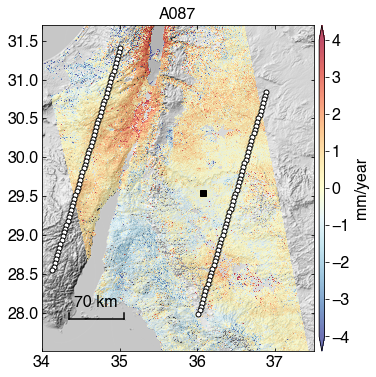

In [26]:
tmp_str   = 'A087' # velo_file.split('.')[0].split('/')[-1]
colormap = 'RdYlBu_r'

cmd =  f'view.py {velo_file} velocity --noverbose '
cmd += f'--pts-file prof_tmp_pts.txt --pts-marker wo --pts-ms 5 '
cmd += f'-m {mask_file} -d {geom_file} -c {colormap} '
cmd += f'--alpha 0.7 --dem-nocontour --shade-exag 0.05 --figtitle {tmp_str} '
cmd += f'--sub-lon 34 37.5 --sub-lat 27.5 31.7  --vlim -4 4 -u mm '
cmd += f'--outfile {pic_dir}/profiles_{tmp_str}.png'
obj = viewer(cmd)
obj.configure()
obj.plot()


ValueError: The lengths of the data (7498) and the error 7497 do not match

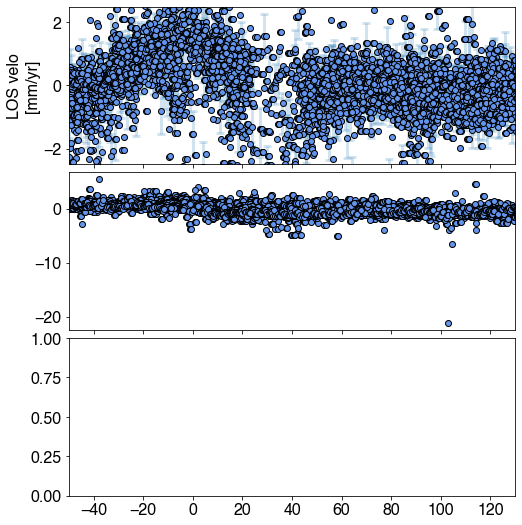

In [27]:
#%% get values along the velocity profiles

x,  z,  res  = transec_pick(velo_file, 'velocity',    'prof_tmp.txt', fmt='lalo', mask_file=mask_file)
xe, ze, rese = transec_pick(velo_file2, 'velocityStd', 'prof_tmp.txt', fmt='lalo', mask_file=mask_file)

#%%  Stack scatter profiles
n     = 20
nplot = int(len(res)/n)
center_shift = 50  # approx center of the fault, set as the distance origin
fig, axs = plt.subplots(figsize=[8, 3*nplot], nrows=int(len(res)/n), sharex=True,  gridspec_kw = {'wspace':0, 'hspace':0.05})
for i in range(nplot):
    ax = axs[i]
    xs = []
    zs = []
    zes= []
    for j in np.arange(i*n, (i+1)*n):
        xs = xs + list(res[j]['distance']/ 1000)
        zs = zs + list(res[j]['value']   * 1000)
        zes= zes+ list(rese[j]['value']  * 1000)
    xs  = np.array(xs) - center_shift
    zs  = np.array(zs) - np.mean(zs)
    zes = np.array(zes)

    ax.scatter(xs, zs, fc='whitesmoke', ec='lightgrey', alpha=0.2)
    markers, caps, bars = ax.errorbar(xs, zs, yerr=1*zes, mfc='cornflowerblue', mec='k',
                                        fmt='o', errorevery=10, elinewidth=3, capsize=4, capthick=3)
    [bar.set_alpha(0.2) for bar in bars]
    [cap.set_alpha(0.2) for cap in caps]
    ax.set_xlim(0-center_shift, 180-center_shift)
    ax.set_ylim(-2.5, 2.5)
    ax.set_ylabel('LOS velo\n[mm/yr]')
    if ax == axs[-1]:
        ax.set_xlabel('Across-fault distance [km]')
axs[0].set_title('All pixels in each profile, demean (vel & 1*ts2vel_std)')
filename = '{}/transects_{}_err.png'.format(pic_dir, n)
plt.savefig(filename, dpi=150, bbox_inches='tight')


/home/ykliu/apps/miniconda3/envs/insar/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ykliu/apps/miniconda3/envs/insar/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/ykliu/apps/miniconda3/envs/insar/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ykliu/apps/miniconda3/envs/insar/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ykliu/apps/miniconda3/envs/insar/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


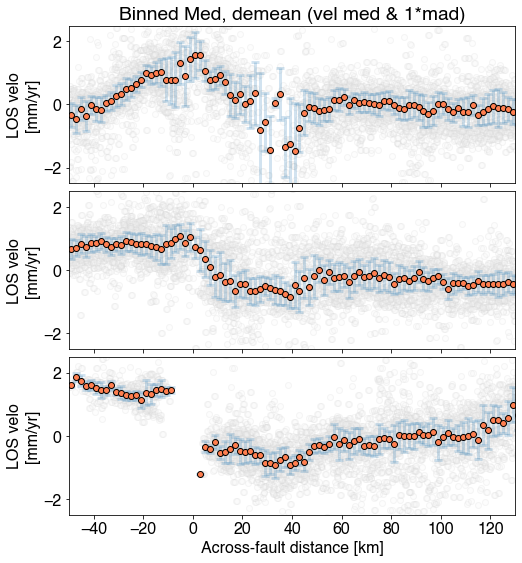

In [33]:
#%% Stack averaged profiles
option = 'L1'

n        = 20         # stack how many profiles
nplot    = int(len(res)/n)
center_shift = 50  # approx center of the fault, set as the distance origin

bin_size = 2      # km; averaged fault-perpendicular distance bin
n_bins   = int(np.abs(max(xs)-min(xs)) / bin_size)


fig, axs = plt.subplots(figsize=[8, 3*nplot], nrows=int(len(res)/n), sharex=True,  gridspec_kw = {'wspace':0, 'hspace':0.05})
for i in range(nplot):
    ax = axs[i]
    xs = []
    zs = []
    zes= []
    for j in np.arange(i*n, (i+1)*n):
        xs = xs + list(res[j]['distance']/ 1000)
        zs = zs + list(res[j]['value']   * 1000)
        zes= zes+ list(rese[j]['value']  * 1000)
    xs  = np.array(xs) - center_shift
    zs  = np.array(zs) - np.mean(zs)
    zes = np.array(zes)

    xs_sort = xs[np.argsort(xs)]
    zs_sort = zs[np.argsort(xs)]

    # L1-norm
    med = []
    mad = []

    # L2-norm
    avg = []
    std = []

    loc = []
    for n_bin in range(n_bins):
        start    =  n_bin    * bin_size - center_shift
        end      = (n_bin+1) * bin_size - center_shift
        if max(xs_sort) < start:
            continue
        start_id = np.where(xs_sort >= start)[0][0]
        end_id   = np.where(xs_sort < end)[0][-1]
        #print(' bin {}, {} pixels'.format(n_bin+1, end_id-start_id))
        med.append(np.median(zs_sort[start_id:end_id]))
        mad.append(np.median(np.abs(zs_sort[start_id:end_id]-np.median(zs_sort[start_id:end_id]))))
        avg.append(np.mean(zs_sort[start_id:end_id]))
        std.append(np.std(zs_sort[start_id:end_id]))
        loc.append((start+end)/2)
    med = np.array(med)
    mad = np.array(mad)
    avg = np.array(avg)
    std = np.array(std)
    loc = np.array(loc)

    if any(option in s for s in ['Avg', 'avg', 'Mean', 'mean', 'L2']):
        t_str = ['Avg', '(vel avg & 1*std)']
        plot_y = avg
        plot_yerr = 1 * std
    elif any(option in s for s in ['Med', 'med', 'median', 'L1']):
        t_str = ['Med', '(vel med & 1*mad)']
        plot_y = med
        plot_yerr = 1 * mad

    ax.scatter(xs, zs, fc='whitesmoke', ec='lightgrey', alpha=0.2)
    markers, caps, bars = ax.errorbar(loc, plot_y, yerr=plot_yerr, mfc='coral', mec='k',
                                        fmt='o', errorevery=1, elinewidth=3, capsize=4, capthick=3)
    [bar.set_alpha(0.2) for bar in bars]
    [cap.set_alpha(0.2) for cap in caps]
    ax.set_xlim(0-center_shift, 180-center_shift)
    ax.set_ylim(-2.5, 2.5)
    ax.set_ylabel('LOS velo\n[mm/yr]')
    if ax == axs[-1]:
        ax.set_xlabel('Across-fault distance [km]')

pic_dir = f'{proj_dir}/pic_supp'
filename = '{}/transects{}_P_{}_{}km_err.png'.format(pic_dir, t_str[0], n, bin_size)
axs[0].set_title('Binned {}, demean {}'.format(t_str[0], t_str[1]))
plt.savefig(filename, dpi=150, bbox_inches='tight')
